#P3 Data Wrangling with MongoDB

###Map Area: San Francisco, CA

#0. Procedure
###Count types of tags in the dataset

To get a rough sense of the data

In [10]:
import xml.etree.cElementTree as ET
import pprint
import re
import codecs
import json

In [11]:
def count_tags(filename):
        # YOUR CODE HERE
        tags = {}
        for event, elem in ET.iterparse(filename):
            if elem.tag not in tags.keys():
                tags[elem.tag] = 1
            else:
                tags[elem.tag] += 1
                
        return tags

In [12]:
print count_tags('san-francisco.osm')

{'node': 1410191, 'nd': 1677325, 'bounds': 1, 'member': 26246, 'tag': 949435, 'relation': 1687, 'way': 154315, 'osm': 1}


###Count number of tag types

In [17]:
lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')


def key_type(element, keys):
    if element.tag == "tag":
        # YOUR CODE HERE
        key = element.get('k')
        if re.search(lower, key):
            keys['lower'] += 1
        elif re.search(lower_colon, key):
            keys['lower_colon'] += 1
        elif re.search(problemchars, key):
            keys['problemchars'] += 1
            if key not in keys['problemchars_dict']:
                keys['problemchars_dict'][key] = 1
            else: 
                keys['problemchars_dict'][key] += 1
        else:
            keys['other'] += 1
            if key not in keys['other_dict']:
                keys['other_dict'][key] = 1
            else: 
                keys['other_dict'][key] += 1
                
    return keys


def process_map(filename):
    keys = {"lower": 0, "lower_colon": 0, "problemchars": 0, 
            "problemchars_dict": {}, "other": 0,
            "other_dict": {}}
    for _, element in ET.iterparse(filename):
        keys = key_type(element, keys)

    return keys

In [19]:
tag_types_dict = process_map('san-francisco.osm')

In [20]:
print tag_types_dict

{'lower': 445870, 'other_dict': {'seamark:daymark:construction': 47, 'addr:street:source': 2, 'gnis:ST_num': 226, 'alt_name2': 1, 'seamark:buoy_special_purpose:status': 5, 'tiger:COUNTYFP': 1, 'seamark:fog_signal:group': 13, 'seamark:radar_transponder:category': 1, 'tiger:zip_right_3': 22, 'seamark:buoy_safe_water:colour': 1, 'tiger:zip_right_5': 1, 'tiger:zip_right_4': 7, 'seamark:daymark:source_date': 57, 'seamark:buoy_lateral:name': 7, 'tiger:zip_right_8': 1, 'service:bicycle:rental': 2, 'seamark:buoy_special_purpose:category': 6, 'tiger:zip_left_7': 1, 'tiger:zip_left_6': 1, 'tiger:zip_left_5': 1, 'tiger:zip_left_4': 16, 'tiger:zip_left_3': 50, 'seamark:platform:source': 1, 'tiger:zip_left_1': 642, 'seamark:daymark:shape': 57, 'seamark:buoy_lateral:system': 9, 'seamark:landmark:source_date': 1, 'parking:condition:both': 16, 'seamark:light:information': 1, 'seamark:beacon_special_purpose:status': 30, 'addr:1:housenumber': 1, 'seamark:fog_signal:sequence': 10, 'Building': 1, 'FG:area

In [21]:
print tag_types_dict['other_dict']

# most of them look like seamark (nautical chart standard), they can be ignored.

{'seamark:daymark:construction': 47, 'addr:street:source': 2, 'gnis:ST_num': 226, 'alt_name2': 1, 'seamark:buoy_special_purpose:status': 5, 'tiger:COUNTYFP': 1, 'seamark:fog_signal:group': 13, 'seamark:radar_transponder:category': 1, 'tiger:zip_right_3': 22, 'seamark:buoy_safe_water:colour': 1, 'tiger:zip_right_5': 1, 'tiger:zip_right_4': 7, 'seamark:daymark:source_date': 57, 'seamark:buoy_lateral:name': 7, 'tiger:zip_right_8': 1, 'service:bicycle:rental': 2, 'seamark:buoy_special_purpose:category': 6, 'tiger:zip_left_7': 1, 'tiger:zip_left_6': 1, 'tiger:zip_left_5': 1, 'tiger:zip_left_4': 16, 'tiger:zip_left_3': 50, 'seamark:platform:source': 1, 'tiger:zip_left_1': 642, 'seamark:daymark:shape': 57, 'seamark:buoy_lateral:system': 9, 'seamark:landmark:source_date': 1, 'parking:condition:both': 16, 'seamark:light:information': 1, 'seamark:beacon_special_purpose:status': 30, 'addr:1:housenumber': 1, 'seamark:fog_signal:sequence': 10, 'Building': 1, 'FG:area': 4, 'tiger:LINEARID': 7, 'NHS'

In [22]:
print len(tag_types_dict['other_dict'])

241


###Auditing Postal codes and Street names

In [5]:
import xml.etree.cElementTree as ET
import pprint
import re
import codecs
import json
from collections import defaultdict

street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)


expected = ["Street", "Avenue", "Boulevard", "Drive", "Court", "Place", "Square", "Lane", "Road", 
            "Trail", "Parkway", "Commons"]

# UPDATE THIS VARIABLE
mapping = { "St": "Street",
            "St.": "Street",
            "Rd.": "Road",
            "Ave": "Avenue"
            }


def audit_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected:
            street_types[street_type].add(street_name)


def audit_postal_code(postal_codes, postal_code):
    if postal_code not in postal_codes:
        postal_codes.add(postal_code)
        print postal_code
        

def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")


def is_postal_code(elem):
    return (elem.attrib['k'] == "addr:postcode")


def audit(osmfile):
    osm_file = open(osmfile, "r")
    street_types = defaultdict(set)
    postal_codes = set()
    for event, elem in ET.iterparse(osm_file, events=("start",)):

        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
#                 if is_street_name(tag):
#                     audit_street_type(street_types, tag.attrib['v'])
                    
                if is_postal_code(tag):
                    audit_postal_code(postal_codes, tag.attrib['v'])

#     return street_types
    return postal_codes

In [6]:
# postal codes audit
p_codes = audit('san-francisco.osm')

94117
94102
94111
94710
94618
94611
94103
94704
94107
94002
94702
94703
94501
94709
94103-3124
94158
94115
94536
94706
94609
94556
94110
94132
94541
94124
94108
94131
94112
94121
94118
94123
94134
94114
94133
94116
94105
94122
94577
94804
94070
94109
94104
94030
94063
94607
94612
94612-2202
94904
94544
94404
94587
94213
94619
94602
94019
94080
94610
94608
94066
94939
94560
94555
94605
94403
94801
94014
94596
94549
94027
94061
94901
94065
94523
94606-3636
94606
94401
94502
94301
94925
94578
1087
94087
94705
94598
94113
90214
94707
94597
94920
93710
CA
94601
94595
94530
94143
94062
94129
94188
94044
94805
94303
94127
94025
CA 94133
94965
94002-3585
94402
94010
CA 94030
94118-4504
94563
CA:94103
94013
94015
CA 94544
94579
94166
94545
94546
94519
94130
94941
94549-5506
94720-1076
515
94301-2019
94017
94621
94603
94117-9991
94115 
94112 
94121 
94708
9412
94720
94613
95498
941234
94552


In [12]:
type(list(p_codes)[0])

str

###Postal codes

- whitespaces --> trim
- CA --> truncate the front
- extension --> truncate the back
- 4 digit, 3 digit --> drop

In [14]:
for code in p_codes:
    if len(code) != 5:
        print '--------'
        print code
        print len(code)
        print ' '

--------
CA 94544
8
 
--------
CA 94133
8
 
--------
CA:94103
8
 
--------
94612-2202
10
 
--------
94118-4504
10
 
--------
1087
4
 
--------
94720-1076
10
 
--------
CA 94030
8
 
--------
94549-5506
10
 
--------
9412
4
 
--------
515
3
 
--------
941234
6
 
--------
94115 
6
 
--------
94606-3636
10
 
--------
94301-2019
10
 
--------
94112 
6
 
--------
CA
2
 
--------
94002-3585
10
 
--------
94121 
6
 
--------
94103-3124
10
 
--------
94117-9991
10
 


In [23]:
for code in p_codes:
    if len(code) != 5:
        print '--------'
        n_string = code.strip('CA:').strip()
        index = n_string.find('-')
        if index > 0:
            print n_string[0:index]
        elif len(n_string) != 5:
            print 'not 5', n_string
        else:
            print n_string

--------
94544
--------
94133
--------
94103
--------
94612
--------
94118
--------
not 5 1087
--------
94720
--------
94030
--------
94549
--------
not 5 9412
--------
not 5 515
--------
not 5 941234
--------
94115
--------
94606
--------
94301
--------
94112
--------
not 5 
--------
94002
--------
94121
--------
94103
--------
94117


In [ ]:
def update_postal_code(code):
    if len(code) != 5:
        n_string = code.strip('CA:').strip()
        index = n_string.find('-')
        if index > 0:
            return n_string[0:index]
        elif len(n_string) != 5:
            return ''
        else:
            return n_string
    else:
        return code

###Street types

In [28]:
st_types = audit('san-francisco.osm')

In [34]:
print sorted(st_types.keys())

['1', '1.3', '120', '12180142', '15th', '170', '2', '24th', '3.2', '300', '4.5', '41276', '9th', 'A', 'Abenue', 'Academy', 'Alameda', 'Alcatraz', 'Alley', 'Arguello', 'Ave', 'Ave.', 'Bay', 'Bluxome', 'Blvd', 'Blvd,', 'Blvd.', 'Boulavard', 'Boulvard', 'Bradshaw', 'Brannan', 'Bridge', 'Bridgeway', 'Broadway', 'California', 'Center', 'Circle', 'Clement', 'Clemente', 'Columbus', 'Cortland', 'Cragmont', 'Cres', 'Crescent', 'Ct', 'Ctr', 'Cut', 'D', 'Dr', 'Dr.', 'E', 'East', 'Embarcadero', 'Everett', 'F', 'Fillmore', 'G', 'Geary', 'H', 'Harrison', 'Highway', 'Hwy', 'I-580', 'I-580)', 'Ic', 'Int', 'Judah', 'King', 'Las', 'Leimert', 'Leslie', 'Lindbergh', 'Ln', 'Ln.', 'Lugano', 'M', 'Mall', 'Market', 'Market/Castro', 'Market/Noe', 'Mission', 'Ness', 'North', 'Oakridge', 'Ora', 'Palms', 'Park', 'Path', 'Peak', 'Pl', 'Plaza', 'Plz', 'Post', 'Powell', 'Pulgas', 'Rd', 'Rd.', 'Real', 'Rhein', 'Rock', 'Schwerin', 'Sobrante', 'Southgate', 'Spencer', 'St', 'St.', 'Steet', 'Steps', 'Sutter', 'Telegraph'

###Some invalid numeric street names

- house number in the wrong place
- 'PM'

###A's

- Abenue
- variants of avenue

###B's

- variants of blvd and broadway

###C's

- variants of crescent and court

###D's

- variants of drive

###H's

- variants of highway

###L's

- variants of lanes and plaza

###R's

- variants of road 

###S's 

- variants of streets

In [40]:
for e in sorted(st_types.keys()):
    print e
    print '---------'
    print st_types[e]
    print ''

1
---------
set(['W Of Us 101 @ Jct Sr 1'])

1.3
---------
set(['ALA 260 PM 1.3'])

120
---------
set(['12th Street #120'])

12180142
---------
set(['12180142'])

15th
---------
set(['15th'])

170
---------
set(['California Street, Suite 170'])

2
---------
set(['San Francisco Bicycle Route 2'])

24th
---------
set(['24th'])

3.2
---------
set(['ALA 84 PM 3.2'])

300
---------
set(['Mission Street #300'])

4.5
---------
set(['SF 80 PM 4.5'])

41276
---------
set(['Upton St 41276'])

9th
---------
set(['9th'])

A
---------
set(['Avenue A', 'Upton St #A'])

Abenue
---------
set(['Columbus Abenue'])

Academy
---------
set(['California College Prep Academy'])

Alameda
---------
set(['Alameda', 'The Alameda'])

Alcatraz
---------
set(['Alcatraz'])

Alley
---------
set(["Kahn's Alley", 'Redfield Alley', 'Hodges Alley'])

Arguello
---------
set(['Arguello'])

Ave
---------
set(['Greenwood Ave', 'Earl Ave', 'West Portal Ave', 'Telegraph Ave', 'Grand Ave', 'University Ave', '45th Ave', 'W 25th 

###Street types cleaning

In [43]:
# UPDATE THIS VARIABLE
mapping = { "Ave.": "Ave",
            "Abenue": "Ave",
            "ave": "Ave",
            "avenue": "Ave",
            "Blvd,": "Blvd",
            "Blvd.": "Blvd",
            "Boulavard": "Blvd",
            "Boulvard": "Blvd",
            "broadway": "Broadway",
            "bush": "Bush",
            "Cres": "Crescent",
            "Ctr": "Center",
            "Dr.": "Dr",
            "Hwy": "Highway",
            "Ln.": "Ln",
            "Plz": "Plaza",
            "parkway": "Parkway", 
            "Rd.": "Rd",
            "Steet": "St",
            "St.": "St",
            "st": "St",
            "street": "St",
            "square": "Square",
            "sutter": "Sutter" }


def update_street_name(name, mapping):

    # YOUR CODE HERE
    k = street_type_re.search(name)
    old = k.group()
    if old not in mapping.keys():
        return name
    else:
        new = mapping[old]
        return name.replace(old, new)


for st_type, ways in st_types.iteritems():
        for name in ways:
            better_name = update_name(name, mapping)
            print name, "=>", better_name

Leimert => Leimert
Willow Rd => Willow Rd
Se Quad I-680 / Rudgear Rd => Se Quad I-680 / Rudgear Rd
Ascot Rd => Ascot Rd
Ygnacio Valley Rd => Ygnacio Valley Rd
San Mateo Rd => San Mateo Rd
Marshlands Rd => Marshlands Rd
Rollins Rd => Rollins Rd
broadway => Broadway
Alameda => Alameda
The Alameda => The Alameda
Bay and Powell => Bay and Powell
Powell => Powell
Columbus Abenue => Columbus Ave
bush => Bush
Indian Rock Path => Indian Rock Path
Oak Street Path => Oak Street Path
Mendocino Path => Mendocino Path
Arden Path => Arden Path
Parnassus Path => Parnassus Path
Oakridge => Oakridge
E Of Center St @ I-580 => E Of Center St @ I-580
San Clemente => San Clemente
Avenue D => Avenue D
Avenue H => Avenue H
Bay => Bay
12th Street #120 => 12th Street #120
Alemany Boulvard => Alemany Blvd
Bancroft Steps => Bancroft Steps
24th => 24th
Kahn's Alley => Kahn's Alley
Redfield Alley => Redfield Alley
Hodges Alley => Hodges Alley
Market/Castro => Market/Castro
Broadway => Broadway
North Broadway => No

###Converting to JSON and preparing for MongoDB 

- step is done in data_prep.py

#1. Problems encountered in the map

After thoroughly auditing the area, there are two main problems with the data:

- different variation of street names 
- different variation of postal codes


###Different variation of streetnames
The different variation of streetnames are programmatically cleaned as indicated by the mapping.


###Different variation of postal codes
The different variation of postal codes are programmatically cleaned.

#2. Data overview

The following section contains some basic statistics about the dataset and the queries used to gather them:

Date of data set: as of Dec 31, 2013

Source of data set: http://metro.teczno.com/#san-francisco

Reason: Living in SF

File sizes:

- san-francisco.osm.json = 359.9MB
- san-francisco.osm = 326.2MB

###Sort postcodes by count, descending

In [2]:
def get_db(db_name):
    from pymongo import MongoClient
    client = MongoClient('localhost:27017')
    db = client[db_name]
    return db


def make_pipeline():
    pipeline = [{"$match": {"address.postcode": {"$exists": 1}}}, 
                {"$group": {"_id": "$address.postcode", "count": {"$sum": 1}}}, 
                {"$sort": {"count":-1}}]
    return pipeline


def map_data(db, pipeline):
    return [doc for doc in db.sf1.aggregate(pipeline)]


if __name__ == '__main__':
    db = get_db('osm_sf')
    pipeline = make_pipeline()
    result = map_data(db, pipeline)
    import pprint
    pprint.pprint(result)
    
# postal codes look mostly correct. some empty strings are the inappropriate ones 
# that are taken out

[{u'_id': u'94063', u'count': 358},
 {u'_id': u'94587', u'count': 250},
 {u'_id': u'94109', u'count': 200},
 {u'_id': u'94103', u'count': 193},
 {u'_id': u'94061', u'count': 161},
 {u'_id': u'94114', u'count': 129},
 {u'_id': u'94113', u'count': 111},
 {u'_id': u'94110', u'count': 65},
 {u'_id': u'94102', u'count': 63},
 {u'_id': u'94107', u'count': 63},
 {u'_id': u'94117', u'count': 43},
 {u'_id': u'94612', u'count': 40},
 {u'_id': u'94123', u'count': 36},
 {u'_id': u'94403', u'count': 34},
 {u'_id': u'94608', u'count': 33},
 {u'_id': u'94704', u'count': 32},
 {u'_id': u'94501', u'count': 30},
 {u'_id': u'94105', u'count': 27},
 {u'_id': u'94118', u'count': 27},
 {u'_id': u'94619', u'count': 25},
 {u'_id': u'94116', u'count': 24},
 {u'_id': u'94122', u'count': 24},
 {u'_id': u'94115', u'count': 23},
 {u'_id': u'94132', u'count': 21},
 {u'_id': u'94108', u'count': 21},
 {u'_id': u'94602', u'count': 19},
 {u'_id': u'94133', u'count': 19},
 {u'_id': u'94112', u'count': 17},
 {u'_id': u'9

### Sort cities by count, descending

In [3]:
def make_pipeline():
    pipeline = [{"$match":{"address.city":{"$exists":1}}}, 
                {"$group":{"_id":"$address.city", "count":{"$sum":1}}}, 
                {"$sort":{"count":-1}}]
    return pipeline


if __name__ == '__main__':
    db = get_db('osm_sf')
    pipeline = make_pipeline()
    result = map_data(db, pipeline)
    import pprint
    pprint.pprint(result)
    
# Several of the cities have several mispellings/variations: 
# San Francisco, Berkeley, Oakland

# Some unexpected ones: 157, 155

[{u'_id': u'Redwood City', u'count': 23533},
 {u'_id': u'Berkeley', u'count': 3346},
 {u'_id': u'Palo Alto', u'count': 1651},
 {u'_id': u'San Francisco', u'count': 1037},
 {u'_id': u'San Francicsco', u'count': 329},
 {u'_id': u'Union City', u'count': 252},
 {u'_id': u'Burlingame', u'count': 158},
 {u'_id': u'Oakland', u'count': 136},
 {u'_id': u'San Mateo', u'count': 38},
 {u'_id': u'Alameda', u'count': 24},
 {u'_id': u'Walnut Creek', u'count': 18},
 {u'_id': u'Hayward', u'count': 15},
 {u'_id': u'Albany', u'count': 14},
 {u'_id': u'San Carlos', u'count': 12},
 {u'_id': u'berkeley', u'count': 10},
 {u'_id': u'Fremont', u'count': 10},
 {u'_id': u'Emeryville', u'count': 8},
 {u'_id': u'Artherton', u'count': 7},
 {u'_id': u'Atherton', u'count': 6},
 {u'_id': u'San Leandro', u'count': 6},
 {u'_id': u'Mill Valley', u'count': 6},
 {u'_id': u'san francisco', u'count': 5},
 {u'_id': u'Pacifica', u'count': 4},
 {u'_id': u'Belmont', u'count': 4},
 {u'_id': u'Menlo Park', u'count': 3},
 {u'_id': 

###Number of documents

In [5]:
if __name__ == '__main__':
    db = get_db('osm_sf')
    result = db.sf1.find().count()
    import pprint
    pprint.pprint(result)

1564506


###Number of nodes

In [8]:
if __name__ == '__main__':
    db = get_db('osm_sf')
    result = db.sf1.find({"type":"node"}).count()
    import pprint
    pprint.pprint(result)

1410114


###Number of ways

In [9]:
if __name__ == '__main__':
    db = get_db('osm_sf')
    result = db.sf1.find({"type":"way"}).count()
    import pprint
    pprint.pprint(result)

154289


###Number of unique

In [17]:
if __name__ == '__main__':
    db = get_db('osm_sf')
    result = len(db.sf1.distinct("created.user"))
    import pprint
    pprint.pprint(result)

1288


###Top 1 contributing user

In [18]:
def make_pipeline():
    pipeline = [{"$group":{"_id": "$created.user", "count":{"$sum": 1}}},
                {"$sort":{"count": -1}}, {"$limit": 1}]
    return pipeline

if __name__ == '__main__':
    db = get_db('osm_sf')
    pipeline = make_pipeline()
    result = map_data(db, pipeline)
    import pprint
    pprint.pprint(result)

[{u'_id': u'oldtopos', u'count': 334076}]


###Number of users having 1 post

In [19]:
def make_pipeline():
    pipeline = [{"$group":{"_id":"$created.user", "count":{"$sum": 1}}}, 
                {"$group":{"_id":"$count", "num_users":{"$sum": 1}}}, 
                {"$sort":{"_id": 1}}, {"$limit": 1}]
    return pipeline

if __name__ == '__main__':
    db = get_db('osm_sf')
    pipeline = make_pipeline()
    result = map_data(db, pipeline)
    import pprint
    pprint.pprint(result)

[{u'_id': 1, u'num_users': 292}]


#3. Additional Ideas

- User contribution is pretty skewed but has a healthy base of contributing users (~200 users contribute to 99% of the content)

- Among the top 500 contributors, most of the contributions are quite old. This might be normal or not (domain knowledge of how quickly SF is developing is required).

In [20]:
def make_pipeline():
    pipeline = [{"$group":{"_id": "$created.user", "count":{"$sum": 1}}},
                {"$sort":{"count": -1}}, {"$limit": 10}]
    return pipeline

if __name__ == '__main__':
    db = get_db('osm_sf')
    pipeline = make_pipeline()
    result = map_data(db, pipeline)
    import pprint
    pprint.pprint(result)

[{u'_id': u'oldtopos', u'count': 334076},
 {u'_id': u'KindredCoda', u'count': 144613},
 {u'_id': u'osmmaker', u'count': 140043},
 {u'_id': u'DanHomerick', u'count': 119462},
 {u'_id': u'nmixter', u'count': 77785},
 {u'_id': u'woodpeck_fixbot', u'count': 46008},
 {u'_id': u'StellanL', u'count': 43335},
 {u'_id': u'oba510', u'count': 38785},
 {u'_id': u'dchiles', u'count': 38472},
 {u'_id': u'Speight', u'count': 30346}]


###User contribution demographics

In [22]:
def make_pipeline():
    pipeline = [{"$group":{"_id": "$created.user", "count":{"$sum": 1}}},
                {"$sort":{"count": -1}}]
    return pipeline

if __name__ == '__main__':
    db = get_db('osm_sf')
    pipeline = make_pipeline()
    user_contribution = map_data(db, pipeline)

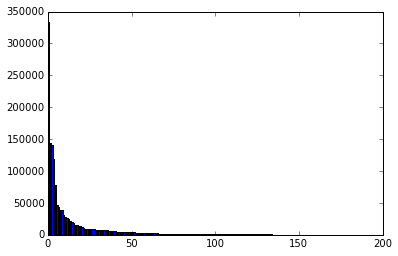

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

x = [i['_id'] for i in user_contribution]
y = [i['count'] for i in user_contribution]

plt.bar(range(len(x)),y)
plt.xlim(0,200)
plt.show()

In [50]:
for j in xrange(50, 550, 50):
    top = sum([i['count'] for i in user_contribution[0:j]])
    whole = float(db.sf1.find().count())
    print 'Top {} users contribute to {} percent of content.'.format(j, top/whole)

Top 50 users contribute to 0.903069722967 percent of content.
Top 100 users contribute to 0.958983858164 percent of content.
Top 150 users contribute to 0.977836454446 percent of content.
Top 200 users contribute to 0.986199477663 percent of content.
Top 250 users contribute to 0.990499237459 percent of content.
Top 300 users contribute to 0.993142244261 percent of content.
Top 350 users contribute to 0.994950482772 percent of content.
Top 400 users contribute to 0.996272944942 percent of content.
Top 450 users contribute to 0.997200394246 percent of content.
Top 500 users contribute to 0.997874089329 percent of content.


In [63]:
def make_pipeline():
    pipeline = [{"$group":{"_id": {"timestamp": "$created.timestamp", 
                    "user": "$created.user"},
                "count":{"$sum": 1}}}]
    return pipeline

if __name__ == '__main__':
    db = get_db('osm_sf')
    pipeline = make_pipeline()
    user_contribution_time = map_data(db, pipeline)

In [89]:
user_contribution_time[0:5]

[{u'_id': {u'timestamp': u'2013-12-17T08:41:01Z', u'user': u'Brian@Brea'},
  u'count': 1},
 {u'_id': {u'timestamp': u'2013-12-17T06:44:10Z', u'user': u'Brian@Brea'},
  u'count': 17},
 {u'_id': {u'timestamp': u'2013-12-16T19:46:29Z', u'user': u'dchiles'},
  u'count': 2},
 {u'_id': {u'timestamp': u'2013-12-16T19:46:27Z', u'user': u'dchiles'},
  u'count': 4},
 {u'_id': {u'timestamp': u'2013-12-14T19:58:30Z', u'user': u'StellanL'},
  u'count': 1}]

In [65]:
import pandas as pd

In [84]:
for i in user_contribution_time:
    try:
        i['_id']['user']
    except:
        print i['_id']

In [83]:
for i in user_contribution_time:
    try:
        i['_id']['user']
    except:
        user_contribution_time.remove(i) # remove the one with no user name

In [86]:
df_user_time_contribution = \
pd.DataFrame({'user': [i['_id']['user'] for i in user_contribution_time],
              'timestamp': [i['_id']['timestamp'] for i in user_contribution_time],
              'count': [i['count'] for i in user_contribution_time]})

In [96]:
df_user_time_contribution['time'] = pd.to_datetime(df_user_time_contribution['timestamp'])

In [100]:
df_user_time_contribution.dtypes

count                 int64
timestamp            object
user                 object
time         datetime64[ns]
dtype: object

In [104]:
df_user_time_contribution['year'] = df_user_time_contribution['time'].apply(lambda x: x.year)

In [195]:
user_time_sums = df_user_time_contribution.groupby(['user', 'year']).sum().unstack().reset_index(level=2, col_level=1)

In [198]:
user_time_sums.columns = user_time_sums.columns.droplevel()

In [208]:
user_time_sums.set_index('user').loc[x[0:500]].sum(0)
# among the top 500 contributors most of the contributions are quite old

year
2007      4101
2008     67897
2009    195716
2010    140365
2011    409696
2012    292355
2013    451050
dtype: float64

###Top 10 amenities

In [209]:
def make_pipeline():
    pipeline = [{"$match": {"amenity":{"$exists":1}}}, 
                {"$group": {"_id":"$amenity", "count":{"$sum": 1}}}, 
                {"$sort": {"count": -1}}, {"$limit": 10}]
    return pipeline

if __name__ == '__main__':
    db = get_db('osm_sf')
    pipeline = make_pipeline()
    result = map_data(db, pipeline)
    import pprint
    pprint.pprint(result)
    
# surprising to see parking is the top 1 result. usually tough to find parking in SF!

[{u'_id': u'parking', u'count': 2958},
 {u'_id': u'restaurant', u'count': 1857},
 {u'_id': u'school', u'count': 1338},
 {u'_id': u'place_of_worship', u'count': 1064},
 {u'_id': u'fire_hydrant', u'count': 698},
 {u'_id': u'post_box', u'count': 588},
 {u'_id': u'cafe', u'count': 574},
 {u'_id': u'bench', u'count': 445},
 {u'_id': u'fast_food', u'count': 436},
 {u'_id': u'drinking_water', u'count': 333}]


###Top 10 religions

In [211]:
def make_pipeline():
    pipeline = [{"$match": {"amenity": {"$exists": 1}, "amenity" : "place_of_worship"}},
                {"$group": {"_id": "$religion", "count": {"$sum": 1}}},
                {"$sort": {"count": -1}}, {"$limit": 10}]
    return pipeline

if __name__ == '__main__':
    db = get_db('osm_sf')
    pipeline = make_pipeline()
    result = map_data(db, pipeline)
    import pprint
    pprint.pprint(result)
    
# Surprise to see scientologist on the list

[{u'_id': u'christian', u'count': 979},
 {u'_id': None, u'count': 45},
 {u'_id': u'buddhist', u'count': 16},
 {u'_id': u'jewish', u'count': 14},
 {u'_id': u'muslim', u'count': 4},
 {u'_id': u'unitarian', u'count': 2},
 {u'_id': u'scientologist', u'count': 2},
 {u'_id': u'shinto', u'count': 1},
 {u'_id': u'unitarian_universalist', u'count': 1}]


###Top 10 cuisines

In [212]:
def make_pipeline():
    pipeline = [{"$match": {"amenity": {"$exists":1}, "amenity": "restaurant"}}, 
                {"$group": {"_id": "$cuisine", "count": {"$sum": 1}}},        
                {"$sort": {"count": -1}}, {"$limit": 10}]
    return pipeline

if __name__ == '__main__':
    db = get_db('osm_sf')
    pipeline = make_pipeline()
    result = map_data(db, pipeline)
    import pprint
    pprint.pprint(result)
    
# Semi-surprise to see the mexican genre take the top spot

[{u'_id': None, u'count': 744},
 {u'_id': u'mexican', u'count': 135},
 {u'_id': u'pizza', u'count': 94},
 {u'_id': u'italian', u'count': 90},
 {u'_id': u'chinese', u'count': 85},
 {u'_id': u'japanese', u'count': 70},
 {u'_id': u'thai', u'count': 70},
 {u'_id': u'american', u'count': 59},
 {u'_id': u'burger', u'count': 54},
 {u'_id': u'indian', u'count': 47}]


##Conclusion

After this review of the data, it's clear that the San Francisco area is incomplete, although things that can be programmatically cleaned are cleaned. One salient feature is that most of the contributions from the contributors are quite old. Given the pace of development in SF, I'd suspect there would be more recent developments that are not captured.